In [2]:
import scipy.io as sio
import mat73
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Import spectral power functions
from neurodsp.spectral import compute_spectrum, rotate_powerlaw

# Import utilities for loading and plotting data
from neurodsp.utils import create_times
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series

In [4]:
datadir = '/Volumes/NONAME/data_for_Yirong'

In [5]:
def remove_multihandles(handles, labels):
    newLabels, newHandles = [], []
    for handle, label in zip(handles, labels):
        if label not in newLabels:
            newLabels.append(label)
            newHandles.append(handle)
    return newHandles, newLabels

# if data prepared

In [6]:
df = pd.read_csv(os.path.join(datadir,'Subject_Info_corrected.csv'),index_col=0)
df_filtered_V4 = df.loc[df.Region=='V4']

In [15]:
def comp_psd(x, T, deltaT):
    """Compute the power spectrum density (PSD) using a Hamming window and direct fft.
    Parameters
    -----------
    x1 : nd array
        time-series from binned data (numTrials * numBin).
    T : float
        duration of each trial/time-series.
    deltaT : float
        temporal resolution of data (or binSize of spike counts).    
    
    
    Returns
    -------
    psd : 1d array
        average  power spectrum density (PSD) across all trials.
    """
    fs = T/deltaT
    n_points = len(x[0])
    x_windowed = (x - x.mean(1)[:,None])*np.hamming(n_points)
    PSD = np.mean(np.abs(np.fft.rfft(x_windowed))**2, axis = 0)[1:-1]
    
    return PSD

In [44]:
def sort_sig_input(sig,atten_cond):
    if len(sig.shape)==2:
        sig = sig.reshape((1,sig.shape[0],sig.shape[1]))
     ## sig (channel, trial, timepoints)
    if atten_cond == 'OUT':
        index = np.random.choice(sig.shape[1],int(sig.shape[1]/2))
        sig = sig[:,index,:]
    avg_sig = np.average(sig, axis=1) # average across trials # (channels, timepoints)
    sig_in = sig.reshape((sig.shape[0]*sig.shape[1],sig.shape[2])) -np.repeat(avg_sig, sig.shape[1], axis=0) # average across channels
    #             print(sig_in.shape)
    return sig_in

In [56]:
def draw_avg_lfp(data, epoch, title, timescales, savepath=False):
    fig, axs = plt.subplots(1, len(epochs), figsize=(25, 4))
    colors = ['plum','c','sandybrown']
    for i, epoch in enumerate(epochs):
        for j, atten_cond in enumerate(['RF','OUT1','OUT2']):
            sig = data[atten_cond][epoch]
            if len(sig.shape)==2:
                sig = sig.reshape((1,sig.shape[0],sig.shape[1]))
            avg_sig = np.average(sig, axis=1) #avg_sig (channel, timepoints) 
            t_axis = (1/fs)*np.arange(0,timescales[i])
            axs[i].plot(t_axis,np.average(avg_sig,axis=0)[0:timescales[i]],label=atten_cond, color=colors[j])
            axs[i].set_title(epoch)
            handles, labels = axs[i].get_legend_handles_labels()
            handles, labels = remove_multihandles(handles, labels)
            axs[i].legend(handles, labels)
    fig.suptitle(title)
    if not savepath:
        plt.show()
    else:
        plt.savefig(savepath)
        plt.close()
        
def draw_avg_psd_algorithm2(data, epochs, title, timescales,savepath=False):
    fig, axs = plt.subplots(1, len(epochs), figsize=(5*len(epochs), 4))
    fs = 1017.375
    colors = ['plum','c','sandybrown']
    for i, epoch in enumerate(epochs):
        for j, atten_cond in enumerate(['RF','OUT']):
            if atten_cond == 'OUT':
                sig1 = sort_sig_input(data['OUT1'][epoch], atten_cond)
                sig2 = sort_sig_input(data['OUT2'][epoch], atten_cond)
                sig_in = np.concatenate((sig1,sig2),axis=0)
            else:
                sig = data[atten_cond][epoch]
                sig_in = sort_sig_input(sig, atten_cond)
            psd = comp_psd(sig_in[:,0:timescales[i]],timescales[i]/fs,1/fs)
            f_axis = np.fft.rfftfreq(timescales[i], 1/fs)[1:-1]
#             f_axis, multi_psd = compute_spectrum(sig_in[:,0:timescales[i]], fs, method='welch', avg_type='mean', nperseg=int(timescales[i]))
#             psd = np.average(multi_psd,axis=0)
            axs[i].plot(f_axis[:int(60*timescales[i]/fs)],psd[:int(60*timescales[i]/fs)],label=atten_cond, color=colors[j])
            axs[i].set_title(epoch)
            axs[i].set_xscale('log')
            axs[i].set_yscale('log')
            handles, labels = axs[i].get_legend_handles_labels()
            handles, labels = remove_multihandles(handles, labels)
            axs[i].legend(handles, labels)
    fig.suptitle(title)
    if not savepath:
        plt.show()
        
    else:
        plt.savefig(savepath)
        plt.close()

In [8]:
fs = 1017.375
scales = [int(fs*0.43), int(fs*1), int(fs*1)]
f_axis = np.fft.rfftfreq(scales[0], 1/fs)[1:-1]

In [57]:
#epochs = ['StationaryDataBiZSc','PostCueDataBiZSc','PreFirstDimDataBiZSc']
epochs = ['PostCueDataBiZSc','PreFirstDimDataBiZSc']
fs = 1017.375
#scales = [int(fs*0.43), int(fs*1), int(fs*1)]
scales = [int(fs*1), int(fs*1)]
layers = ['Infra','Supra','Granr']
for i in range(len(df_filtered_V4)):
    monkey_id = int(df_filtered_V4.iloc[i]['MonkeyID'])
    monkey_name = df_filtered_V4.iloc[i]['MonkeyName']
    sid = df_filtered_V4.iloc[i]['SessionID']
    region = df_filtered_V4.iloc[i]['Region']
    filepath = os.path.join(datadir,'M%d%s-LFP/%s_%s_LFP_%s_sorted.mat'%(monkey_id,region,monkey_name,region,sid))
    figurepath = os.path.join(datadir,'raw_data_figure/M%d%s'%(monkey_id,region))
    data = mat73.loadmat(filepath)
    lfp = data['LfpStruct']['Sorted']

    for layer in layers: 
        if df_filtered_V4.iloc[i]['ChNum_'+layer] != 0: 
            #draw_avg_lfp(lfp['Full'][layer],epochs,layer,scales)
            draw_avg_psd_algorithm2(lfp['Full'][layer],epochs,layer,scales,savepath=os.path.join(figurepath+'_PSD','log_M%d%s_PEN%03d_%s_PSD.png'%(monkey_id,region,int(sid[3:]),layer)))


In [51]:
from PIL import Image

In [50]:
def get_concat_v(Img_file_1,Img_file_2,Img_file_3):
    im1 = Image.open(Img_file_1)
    im2 = Image.open(Img_file_2)
    im3 = Image.open(Img_file_3)
    dst = Image.new('RGB', (im1.width, im1.height + im2.height + im3.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    dst.paste(im3, (0, im1.height + im2.height))
    return dst

In [58]:
df_allLayers_v4 = df_filtered_V4.loc[(df_filtered_V4.ChNum_Granr>0)&(df_filtered_V4.ChNum_Supra>0)&(df_filtered_V4.ChNum_Infra>0)]


for i in range(len(df_allLayers_v4)):
    monkey_id = int(df_allLayers_v4.iloc[i]['MonkeyID'])
    monkey_name = df_allLayers_v4.iloc[i]['MonkeyName']
    sid = df_allLayers_v4.iloc[i]['SessionID']
    region = df_allLayers_v4.iloc[i]['Region']
    figurepath = os.path.join(datadir,'raw_data_figure/M%d%s'%(monkey_id,region))

    Img_file_1 = os.path.join(figurepath+'_PSD','log_M%d%s_PEN%03d_%s_PSD.png'%(monkey_id,region,int(sid[3:]),'Supra'))
    Img_file_2 = os.path.join(figurepath+'_PSD','log_M%d%s_PEN%03d_%s_PSD.png'%(monkey_id,region,int(sid[3:]),'Granr'))
    Img_file_3 = os.path.join(figurepath+'_PSD','log_M%d%s_PEN%03d_%s_PSD.png'%(monkey_id,region,int(sid[3:]),'Infra'))
    Imgout = get_concat_v(Img_file_1,Img_file_2,Img_file_3)
    Imgout.save(os.path.join(figurepath+'_PSD','log_M%d%s_PEN%03d_PSD.png'%(monkey_id,region,int(sid[3:]))))
    
    

In [27]:
Monkeys = ['Wyman','Taylor']
#epochs = ['StationaryDataBiZSc','PostStimDataBiZSc','PostCueDataBiZSc','PreFirstDimDataBiZSc']
epochs = ['StationaryDataBiZSc','PostCueDataBiZSc','PreFirstDimDataBiZSc']
fs = 1017.375
#scales = [int(fs*0.43), int(fs*0.63), int(fs*1), int(fs*1)]
scales = [int(fs*0.43), int(fs*1), int(fs*1)]
layers = ['Infra','Supra','Granr']
for i in range(len(df_filtered_V4)):
    monkey_id = int(df_filtered_V4.iloc[i]['MonkeyID'])
    monkey_name = Monkeys[monkey_id-1]
    sid = df_filtered_V4.iloc[i]['SessionID']
    region = df_filtered_V4.iloc[i]['Region']
    filepath = os.path.join(datadir,'M%d%s-LFP/%s_%s_LFP_%s_sorted.mat'%(monkey_id,region,monkey_name,region,sid))
    figurepath = os.path.join(datadir,'raw_data_figure/M%d%s'%(monkey_id,region))
    data = mat73.loadmat(filepath)
    lfp = data['LfpStruct']['Sorted']
    
    for layer in layers: 
        if df_filtered_V4.iloc[i]['ChNum_'+layer] != 0: 
            draw_avg_lfp(lfp['Full'][layer],epochs,layer,scales,savepath=os.path.join(figurepath+'_LFP','M%d%s_PEN%03d_%s_LFP.png'%(monkey_id,region,int(sid[3:]),layer)))
            draw_avg_psd_algorithm2(lfp['Full'][layer],epochs,layer,scales,savepath=os.path.join(figurepath+'_PSD','M%d%s_PEN%03d_%s_PSD.png'%(monkey_id,region,int(sid[3:]),layer)))


In [5]:
def draw_avg_lfp(data,epoch,title,savepath=False):
    fig, axs = plt.subplots(1, 5, figsize=(25, 4))
    colors = ['plum','c','sandybrown']
    for i, epoch in enumerate(epochs):
        for j, atten_cond in enumerate(['RF','OUT1','OUT2']):
            sig = data[atten_cond][epoch]
            if len(sig.shape)==2:
                sig = sig.reshape((1,sig.shape[0],sig.shape[1]))
            avg_sig = np.average(sig, axis=1) #avg_sig (channel, timepoints) 
            t_axis = (1/1024)*np.arange(0,1024)
            for channel in range(sig.shape[0]):
                axs[i].plot(t_axis,avg_sig[channel],label=atten_cond, color=colors[j])
            axs[i].set_title(epoch)
            handles, labels = axs[i].get_legend_handles_labels()
            handles, labels = remove_multihandles(handles, labels)
            axs[i].legend(handles, labels)
    fig.suptitle(title)
    if not savepath:
        plt.show()
    else:
        plt.savefig(savepath)
        plt.close()

In [6]:
def draw_avg_psd_algorithm1(data, epochs, title, method='welch',avg_type='mean',savepath=False):
    fig, axs = plt.subplots(1, 5, figsize=(25, 4))
    fs = 1017.375
    f_axis = np.fft.rfftfreq(1024, 1/fs)[1:-1]
    colors = ['plum','c','sandybrown']
    for i, epoch in enumerate(epochs):
        for j, atten_cond in enumerate(['RF','OUT1','OUT2']):
            sig = data[atten_cond][epoch]
            if len(sig.shape)==2:
                sig = sig.reshape((1,sig.shape[0],sig.shape[1]))
            ## sig (channel, trial, timepoints)
            for channel in range(sig.shape[0]):
                if method == 'welch':
                    freq, psd = compute_spectrum(sig[channel], fs, method=method, avg_type=avg_type)
                else:
                    freq, psd = compute_spectrum(sig[channel], fs, method=method)
                channel_psd = np.average(psd, axis=0)
                axs[i].plot(f_axis[:20],channel_psd[:20],label=atten_cond, color=colors[j])
            axs[i].set_title(epoch)
            handles, labels = axs[i].get_legend_handles_labels()
            handles, labels = remove_multihandles(handles, labels)
            axs[i].legend(handles, labels)
    fig.suptitle(title)
    if not savepath:
        plt.show()
    else:
        plt.savefig(savepath)
        plt.close()

In [436]:
def draw_avg_psd_algorithm2(data, epochs, title, method='welch',avg_type='mean',savepath=False):
    fig, axs = plt.subplots(1, 5, figsize=(25, 4))
    fs = 1017.375
    f_axis = np.fft.rfftfreq(1024, 1/fs)[1:-1]
    colors = ['plum','c','sandybrown']
    for i, epoch in enumerate(epochs):
        for j, atten_cond in enumerate(['RF','OUT1','OUT2']):
            sig = data[atten_cond][epoch]
            if len(sig.shape)==2:
                sig = sig.reshape((1,sig.shape[0],sig.shape[1]))
            avg_sig = np.average(sig, axis=1)
            
            ## sig (channel, trial, timepoints)
            for channel in range(sig.shape[0]):
                if method == 'welch':
                    freq, psd = compute_spectrum(sig[channel]-avg_sig[channel], fs, method=method, avg_type=avg_type)
                else:
                    freq, psd = compute_spectrum(sig[channel]-avg_sig[channel], fs, method=method)
                channel_psd = np.average(psd, axis=0)
                axs[i].plot(f_axis[:20],channel_psd[:20],label=atten_cond, color=colors[j])
            axs[i].set_title(epoch)
            handles, labels = axs[i].get_legend_handles_labels()
            handles, labels = remove_multihandles(handles, labels)
            axs[i].legend(handles, labels)
    fig.suptitle(title)
    if not savepath:
        plt.show()
        
    else:
        plt.savefig(savepath)
        plt.close()

In [ ]:
Monkeys = ['Wyman','Taylor']
epochs = ['StationaryDataBiZSc','PostCueDataBiZSc','PreFirstDimDataBiZSc']
fs = 1017.375
scales = [int(fs*0.43), int(fs*0.63), int(fs*1)]
layers = ['Infra','Supra','Granr']
for i in range(len(df_filtered_V4)):
    monkey_id = int(df_filtered_V4.iloc[i]['MonkeyID'])
    monkey_name = Monkeys[monkey_id-1]
    sid = int(df_filtered_V4.iloc[i]['SessionID'])
    region = int(df_filtered_V4.iloc[i]['Region'])
    filepath = os.path.join(datadir,'M%d%s-LFP/%s_%s_LFP_PEN%d_sorted.mat'%(monkey_id,region,monkey_name,region,sid))
    figurepath = os.path.join(datadir,'raw_data_figure/M%d%s'%(monkey_id,region))
    data = mat73.loadmat(filepath)
    lfp = data['LfpStruct']['Sorted']
    for layer in layers: 
        draw_avg_lfp(lfp['Full'][layer],epochs,title=layer,savepath=os.path.join(figurepath+'_LFP','M%d%s_PEN%03d_%s_LFP.png'%(monkey_id,region,sid,layer)))
        draw_avg_psd_algorithm1(lfp['Full'][layer],epochs,title=layer,savepath=os.path.join(figurepath+'_PSD1','M%d%s_PEN%03d_%s_PSD1.png'%(monkey_id,region,sid,layer)))
        draw_avg_psd_algorithm2(lfp['Full'][layer],epochs,title=layer,savepath=os.path.join(figurepath+'_PSD2','M%d%s_PEN%03d_%s_PSD2.png'%(monkey_id,region,sid,layer)))


## check unfinished

In [441]:
df_filtered_V4 = df.loc[df.Region=='V4']
Monkeys = ['Wyman','Taylor']
epochs = ['StationaryDataBiZSc','PostCueDataBiZSc','PreFirstDimDataBiZSc','PreSecondDimDataBiZSc','PreThirdDimDataBiZSc']
layers = ['Infra','Supra','Granr']
for i in range(len(df_filtered_V4)):
    monkey_id = int(df_filtered_V4.iloc[i]['MonkeyID'])
    monkey_name = Monkeys[monkey_id-1]
    sid = int(df_filtered_V4.iloc[i]['SessionID'][3:])
    region = df_filtered_V4.iloc[i]['Region']
    filepath = os.path.join(datadir,'M%d%s-LFP/%s_%s_LFP_PEN%d_sorted.mat'%(monkey_id,region,monkey_name,region,sid))
    figurepath = os.path.join(datadir,'raw_data_figure/M%d%s'%(monkey_id,region))
    for layer in layers: 
        if not os.path.exists(os.path.join(figurepath+'_LFP','M%d%s_PEN%03d_%s_LFP.png'%(monkey_id,region,sid,layer))):
            print('M%d%s_PEN%03d_%s not exist'%(monkey_id,region,sid,layer))


M1V4_PEN303_Granr not exist
M1V4_PEN311_Infra not exist
M1V4_PEN322_Granr not exist
M2V4_PEN018_Infra not exist
M2V4_PEN027_Supra not exist
M2V4_PEN003_Infra not exist
M2V4_PEN003_Granr not exist
M2V4_PEN030_Supra not exist
M2V4_PEN033_Supra not exist


# datainfo
## get common session --> txt

In [3]:
def get_sessions(foldername):
    elements = glob.glob(os.path.join(datadir,foldername,'*'))
    PEN_list = []
    for element in elements:
        z = re.findall("PEN\d+",element)
        PEN_list.append(z[0])
    return PEN_list

def get_common_sessions(monkeyID):
    PEN_list0 = set(get_sessions(monkeyID+'V4-LFP'))
    PEN_list1 = set(get_sessions(monkeyID+'V1-LFP'))
    return PEN_list0.intersection(PEN_list1)

In [4]:
PEN_M1 = get_common_sessions('M1')
PEN_M2 = get_common_sessions('M2')
with open(os.path.join(datadir,'M1_PEN.txt'), 'w') as fp:
    for item in sorted(PEN_M1):
        fp.write("%s\n" % item)
    print('M1 Done')
with open(os.path.join(datadir,'M2_PEN.txt'), 'w') as fp:
    for item in sorted(PEN_M2):
        fp.write("%s\n" % item)
    print('M2 Done')
      

M1 Done
M2 Done


## trial and channel info --> csv

In [18]:
PEN_M1 = np.loadtxt(os.path.join(datadir,'M1_PEN.txt'),dtype='str')
PEN_M2 = np.loadtxt(os.path.join(datadir,'M2_PEN.txt'),dtype='str')
Info_li = ['MonkeyID','Region','SessionID', 
           'TrialNum','TrialNum_RF','TrialNum_OUT1','TrialNum_OUT2',
           'ChNum_Supra','ChNum_Infra','ChNum_Granr']
DF_M1 = pd.DataFrame(np.zeros((2*len(PEN_M1),len(Info_li))),columns=Info_li)
DF_M2 = pd.DataFrame(np.zeros((2*len(PEN_M2),len(Info_li))),columns=Info_li)

In [31]:
for i, penid in enumerate(PEN_M2):
    try:
        data = mat73.loadmat(os.path.join(datadir,'M2V1-LFP/Taylor_V1_LFP_%s_sorted.mat'%penid))
#         data = mat73.loadmat(os.path.join(datadir,'M2V4-LFP/Taylor_V4_LFP_%s_sorted.mat'%penid))
        lfp = data['LfpStruct']['Sorted']
        trial_rf = lfp['Full']['Granr']['RF']['gratCondFirstDim'].shape[0]
        trial_out1 = lfp['Full']['Granr']['OUT1']['gratCondFirstDim'].shape[0]
        trial_out2 = lfp['Full']['Granr']['OUT2']['gratCondFirstDim'].shape[0]
#         DF_M2.loc[i] = np.array([2,4,int(penid[3:]),len(lfp['Labels']['Outcome']),trial_rf,trial_out1,trial_out2,lfp['Labels']['SupraChsLamAlignsBi'].size,lfp['Labels']['InfraChsLamAlignsBi'].size,lfp['Labels']['GranrChsLamAlignsBi'].size])
        DF_M2.loc[i+len(PEN_M2)] = np.array([2,1,int(penid[3:]),len(lfp['Labels']['Outcome']),trial_rf,trial_out1,trial_out2,lfp['Labels']['SupraChsLamAlignsBi'].size,lfp['Labels']['InfraChsLamAlignsBi'].size,lfp['Labels']['GranrChsLamAlignsBi'].size])

    except: 
#         data = sio.loadmat(os.path.join(datadir,'M1V4-LFP/Wyman_V4_LFP_%s_sorted.mat'%penid))
        print(penid)
            

In [53]:
df = pd.concat((DF_M1,DF_M2),axis=0,ignore_index=True)
df.to_csv(os.path.join(datadir,'BasicInfo.csv'))

In [26]:
for i, penid in enumerate(PEN_M1):
    try:
        data = mat73.loadmat(os.path.join(datadir,'M1V1-LFP/Wyman_V1_LFP_%s_sorted.mat'%penid))
#         data = mat73.loadmat(os.path.join(datadir,'M1V4-LFP/Wyman_V4_LFP_%s_sorted.mat'%penid))
        lfp = data['LfpStruct']['Sorted']
        trial_rf = lfp['Full']['Granr']['RF']['gratCondFirstDim'].shape[0]
        trial_out1 = lfp['Full']['Granr']['OUT1']['gratCondFirstDim'].shape[0]
        trial_out2 = lfp['Full']['Granr']['OUT2']['gratCondFirstDim'].shape[0]
#         DF_M1.loc[i] = np.array([1,4,int(penid[3:]),len(lfp['Labels']['Outcome']),trial_rf,trial_out1,trial_out2,lfp['Labels']['SupraChsLamAlignsBi'].size,lfp['Labels']['InfraChsLamAlignsBi'].size,lfp['Labels']['GranrChsLamAlignsBi'].size])
        DF_M1.loc[i+len(PEN_M1)] = np.array([1,1,int(penid[3:]),len(lfp['Labels']['Outcome']),trial_rf,trial_out1,trial_out2,lfp['Labels']['SupraChsLamAlignsBi'].size,lfp['Labels']['InfraChsLamAlignsBi'].size,lfp['Labels']['GranrChsLamAlignsBi'].size])

    except: 
#         data = sio.loadmat(os.path.join(datadir,'M1V4-LFP/Wyman_V4_LFP_%s_sorted.mat'%penid))
        print(penid)
        

# datainfo from their code

In [380]:
def get_subjInfo(mid):
    Info_li = ['MonkeyID','MonkeyName','Region','SessionID', 
           'TrialNum','ChNum_Supra','ChNum_Infra','ChNum_Granr']
    data = sio.loadmat(os.path.join(datadir,'monkeyInfo.mat'))['m%dINFO'%mid]
    penIds = np.loadtxt(os.path.join(datadir,'M%d_PEN.txt'%mid),dtype='str')
    all_penIds = data['penIDs'][0][0][0]
    df = pd.DataFrame(np.zeros((2*len(penIds),len(Info_li))),columns=Info_li)
    df.MonkeyName = df.MonkeyName.astype(str)
    df.Region = df.Region.astype(str)
    monkeyName = data[0][0][0][0]
    k = 0
    for penid in penIds:
        i = np.where(all_penIds==int(penid[3:]))[0][0]
        for j, region in enumerate(['V1','V4']):
            lfpData = mat73.loadmat(os.path.join(datadir,'M%d%s-LFP/%s_%s_LFP_%s_sorted.mat'%(mid,region,monkeyName,region,penid)))
            chIds = data['penInfos'][0][0][0][i][j+1][0][0][1]
            seChs = data['penInfos'][0][0][0][i][j+1][0][0][-1]
            seIds = [np.where(chIds[0]==chId)[0][0] for chId in seChs[0]]
            seLayers = [data['penInfos'][0][0][0][i][j+1][0][0][-2].flatten()[index][0] for index in seIds]
            ChNum_Supra = seLayers.count('S')
            ChNum_Infra = seLayers.count('I')
            ChNum_Granr = seLayers.count('G')
            trialsNum = len(lfpData['LfpStruct']['Sorted']['Labels']['Outcome'])
            df.iloc[k] = [mid,monkeyName,region,penid,trialsNum,ChNum_Supra,ChNum_Infra,ChNum_Granr]
            k=k+1
    return df
        

In [383]:
df_M1,df_M2 = get_subjInfo(1), get_subjInfo(2)
df = pd.concat((df_M1,df_M2),axis=0,ignore_index=True)
df.to_csv(os.path.join(datadir,'Subject_Info.csv'))

In [392]:
zero_df = df.loc[(df.Region=='V4')&((df.ChNum_Granr==0)|(df.ChNum_Infra==0)|(df.ChNum_Supra==0))]

In [61]:
def draw_avg_psd_algorithm_diff(data, epochs, title, method='welch',avg_type='mean',verbose=True):
    fig, axs = plt.subplots(1, 5, figsize=(25, 4))
    fs = 1017.375
    f_axis = np.fft.rfftfreq(1024, 1/fs)[1:-1]
    colors = ['plum','c','sandybrown']
    for i, epoch in enumerate(epochs):
        for j, atten_cond in enumerate(['RF','OUT1','OUT2']):
            sig = data[atten_cond][epoch]
            if len(sig.shape)==2:
                sig = sig.reshape((1,sig.shape[0],sig.shape[1]))
            avg_sig = np.average(sig, axis=1)
#             print(avg_sig)
            ## sig (channel, trial, timepoints)
            for channel in range(sig.shape[0]):
                freq1, psd1 = compute_spectrum(sig[channel], fs, method=method, avg_type=avg_type)
                freq2, psd2 = compute_spectrum(sig[channel]-avg_sig[channel], fs, method=method, avg_type=avg_type)
                channel_psd1 = np.average(psd1, axis=0)
                channel_psd2 = np.average(psd2, axis=0)
                diff = channel_psd1 - channel_psd2
                labels = plt.gca().get_legend_handles_labels()
                axs[i].plot(f_axis[:20],diff[:20],label=atten_cond, color=colors[j])
            axs[i].set_title(epoch)
            handles, labels = axs[i].get_legend_handles_labels()
            handles, labels = remove_multihandles(handles, labels)
            axs[i].legend(handles, labels)
    fig.suptitle(title)
    plt.show()


In [19]:
def draw_avg_vsd(data,epoch,title,meth):
    fig, axs = plt.subplots(1, 5, figsize=(25, 4))
    for i, epoch in enumerate(epochs):
        for atten_cond in ['RF','OUT1','OUT2']:
            sig = data[atten_cond][epoch]
            if len(sig.shape)==2:
                sig = sig.reshape((1, sig.shape[0],sig.shape[1]))
            sig = np.average(np.average(sig,axis=1),axis=0)
            fs = 1017.375
    
            if method == 'welch':
                freq, psd = compute_spectrum(sig, fs, method=method, avg_type=avg_type)
            else:
                freq, psd = compute_spectrum(sig, fs, method=method)
    # Calculate the spectral histogram
    freqs, bins, spect_hist = compute_spectral_hist(sig, fs, nbins=50, f_range=(0, 80),
                                                    cut_pct=(0.1, 99.9))

    # Calculate a power spectrum, with median Welch
    freq_med, psd_med = compute_spectrum(sig, fs, method='welch',
                                         avg_type='median', nperseg=fs*2)
    
    # Plot the spectral histogram
    plot_spectral_hist(freqs, bins, spect_hist, freq_med, psd_med)

In [170]:
Monkeys = ['Wyman','Taylor']
epochs = ['StationaryDataBiZSc','PostCueDataBiZSc','PreFirstDimDataBiZSc','PreSecondDimDataBiZSc','PreThirdDimDataBiZSc']
layers = ['Infra','Supra','Granr']
for i in range(len(df_filtered_V4)):
    monkey_id = int(df_filtered_V4.iloc[i]['MonkeyID'])
    monkey_name = Monkeys[monkey_id-1]
    sid = int(df_filtered_V4.iloc[i]['SessionID'])
    region = int(df_filtered_V4.iloc[i]['Region'])
    filepath = os.path.join(datadir,'M%d%s-LFP/%s_%s_LFP_PEN%d_sorted.mat'%(monkey_id,region,monkey_name,region,sid))
    figurepath = os.path.join(datadir,'raw_data_figure/M%d%s'%(monkey_id,region))
    data = mat73.loadmat(filepath)
    lfp = data['LfpStruct']['Sorted']
    for layer in layers: 
        draw_avg_lfp(lfp['Full'][layer],epochs,title=layer,savepath=os.path.join(figurepath+'_LFP','M%d%s_PEN%03d_%s_LFP.png'%(monkey_id,region,sid,layer)))
        draw_avg_psd_algorithm1(lfp['Full'][layer],epochs,title=layer,savepath=os.path.join(figurepath+'_PSD1','M%d%s_PEN%03d_%s_PSD1.png'%(monkey_id,region,sid,layer)))
        draw_avg_psd_algorithm2(lfp['Full'][layer],epochs,title=layer,savepath=os.path.join(figurepath+'_PSD2','M%d%s_PEN%03d_%s_PSD2.png'%(monkey_id,region,sid,layer)))


700.9615384615385


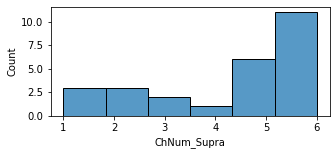

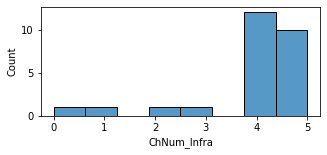

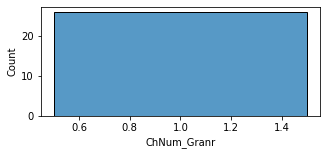

In [461]:
import seaborn as sbn

print(np.mean(df.loc[(df.MonkeyID==2)&(df.Region=='V4')]['TrialNum']))
plt.figure(figsize=(5,2))
sbn.histplot(df.loc[(df.MonkeyID==2)&(df.Region=='V4')]['ChNum_Supra'])
plt.show()
plt.figure(figsize=(5,2))
sbn.histplot(df.loc[(df.MonkeyID==2)&(df.Region=='V4')]['ChNum_Infra'])
plt.show()
plt.figure(figsize=(5,2))
sbn.histplot(df.loc[(df.MonkeyID==2)&(df.Region=='V4')]['ChNum_Granr'])
plt.show()

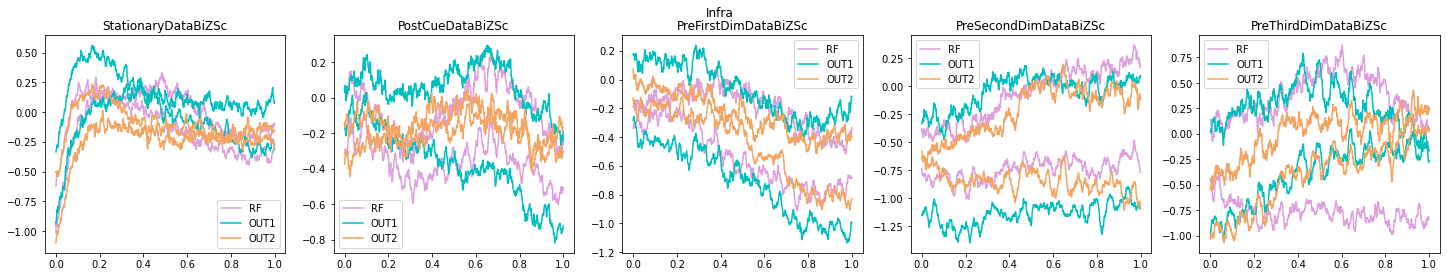

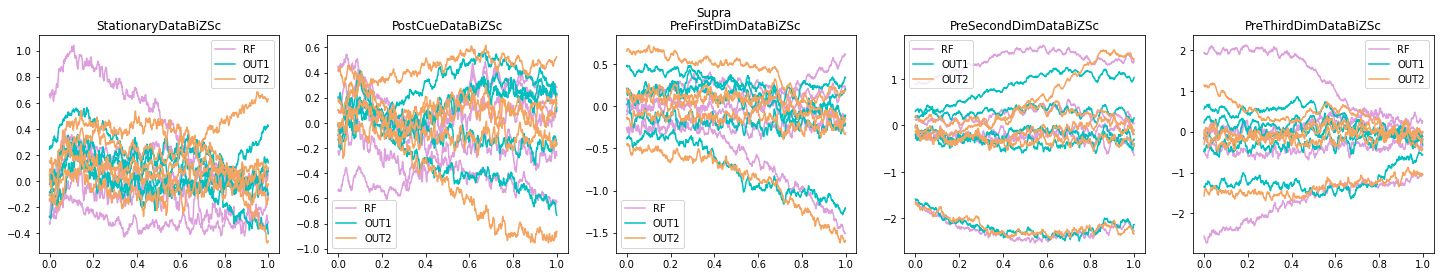

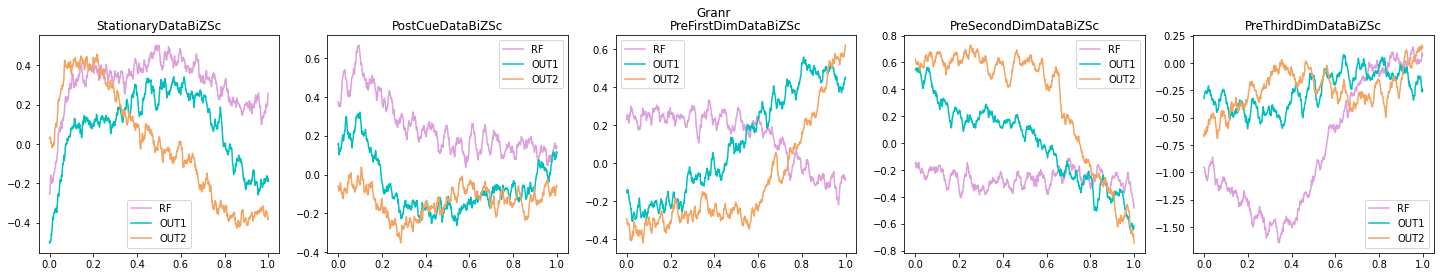

In [81]:
epochs = ['StationaryDataBiZSc','PostCueDataBiZSc','PreFirstDimDataBiZSc','PreSecondDimDataBiZSc','PreThirdDimDataBiZSc']
draw_avg_lfp(lfp['Full']['Infra'],epochs,title='Infra')
draw_avg_lfp(lfp['Full']['Supra'],epochs,title='Supra')
draw_avg_lfp(lfp['Full']['Granr'],epochs,title='Granr')



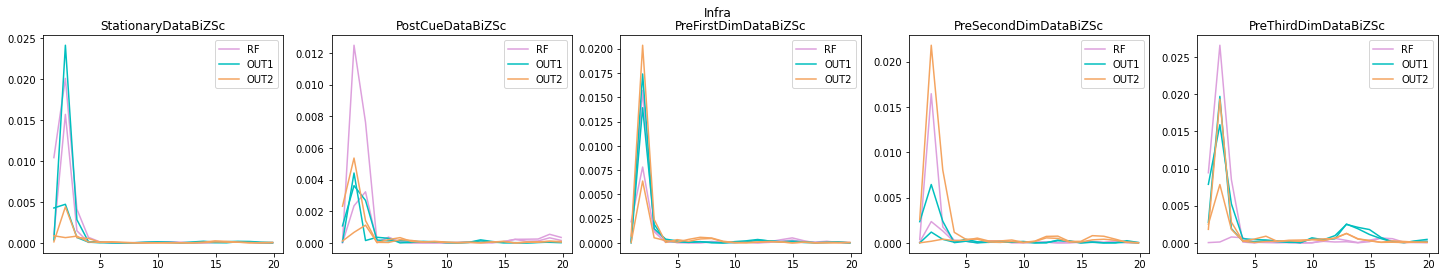

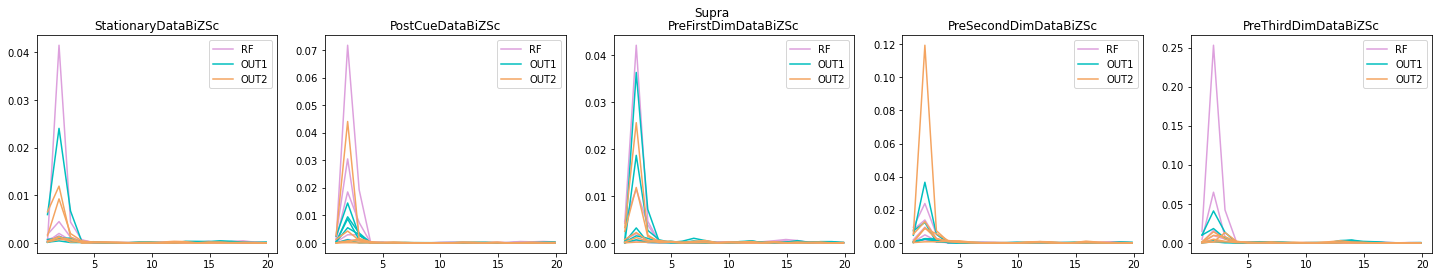

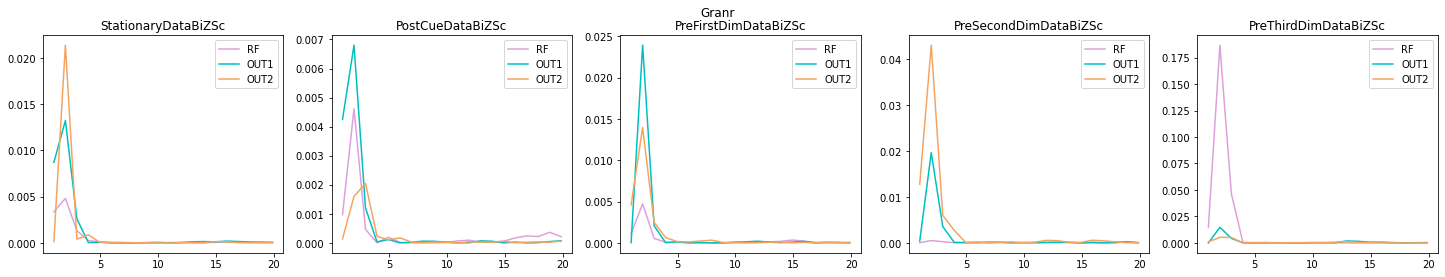

In [62]:
epochs = ['StationaryDataBiZSc','PostCueDataBiZSc','PreFirstDimDataBiZSc','PreSecondDimDataBiZSc','PreThirdDimDataBiZSc']
draw_avg_psd_algorithm_diff(lfp['Full']['Infra'],epochs,title='Infra',avg_type='median')
draw_avg_psd_algorithm_diff(lfp['Full']['Supra'],epochs,title='Supra',avg_type='median')
draw_avg_psd_algorithm_diff(lfp['Full']['Granr'],epochs,title='Granr',avg_type='median')



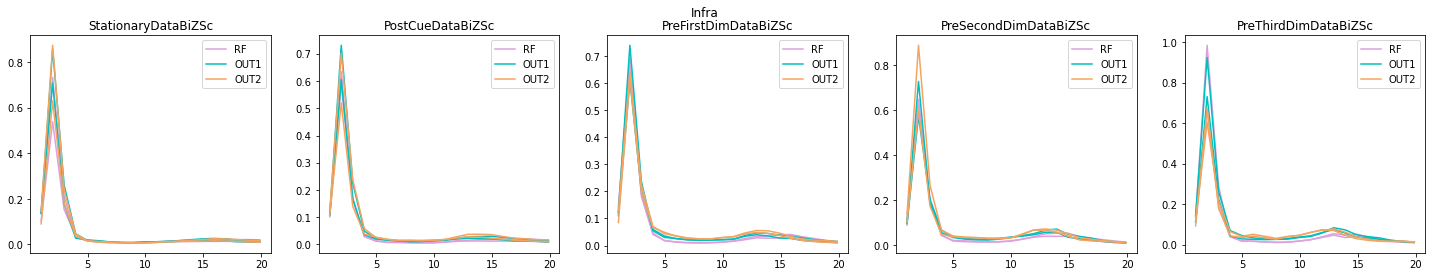

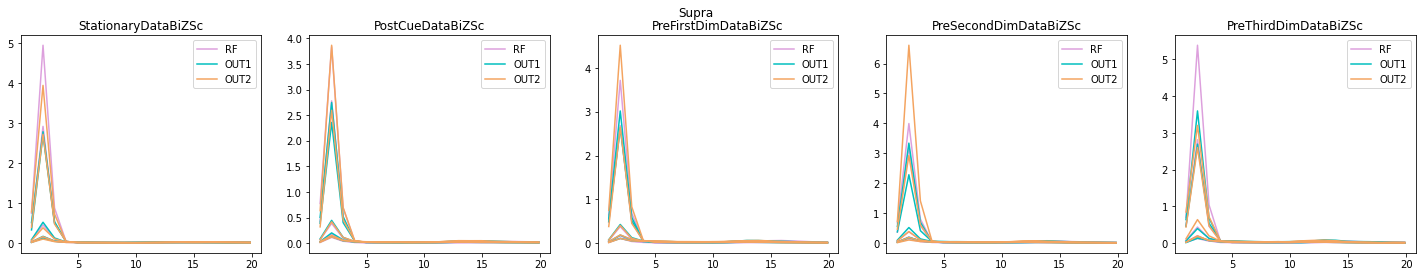

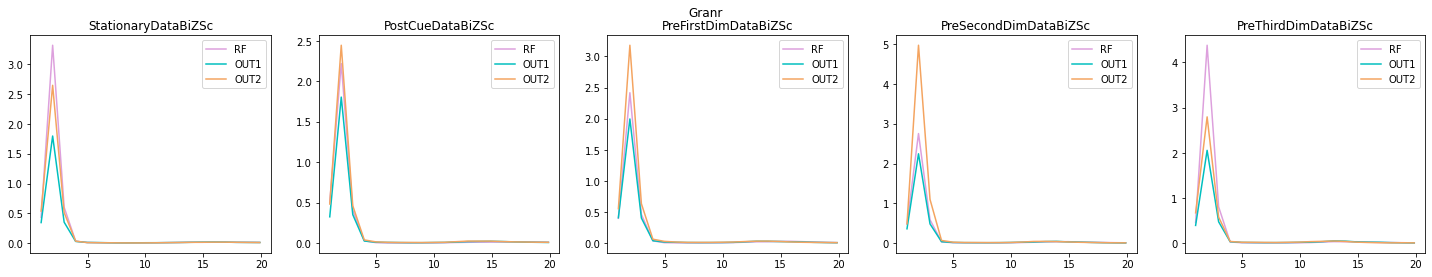

In [69]:
epochs = ['StationaryDataBiZSc','PostCueDataBiZSc','PreFirstDimDataBiZSc','PreSecondDimDataBiZSc','PreThirdDimDataBiZSc']
draw_avg_psd_algorithm1(lfp['Full']['Infra'],epochs,title='Infra',avg_type='median')
draw_avg_psd_algorithm1(lfp['Full']['Supra'],epochs,title='Supra',avg_type='median')
draw_avg_psd_algorithm1(lfp['Full']['Granr'],epochs,title='Granr',avg_type='median')



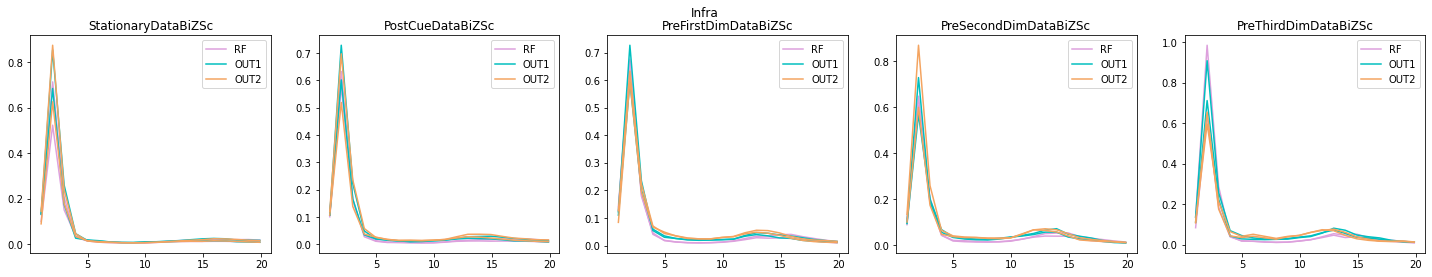

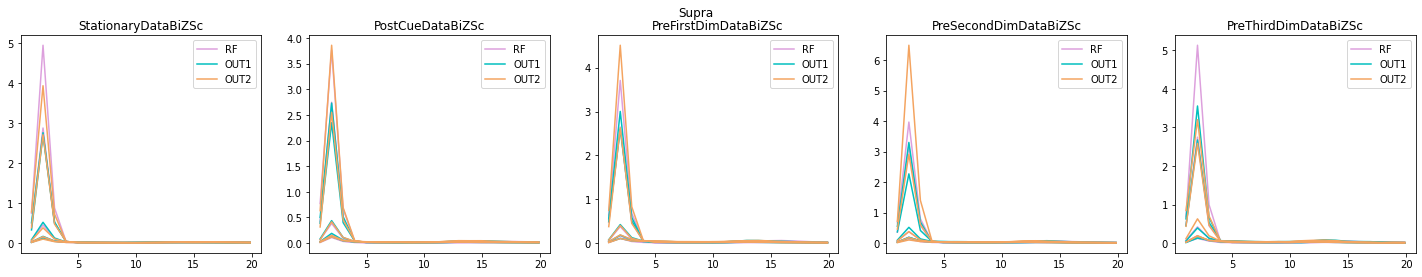

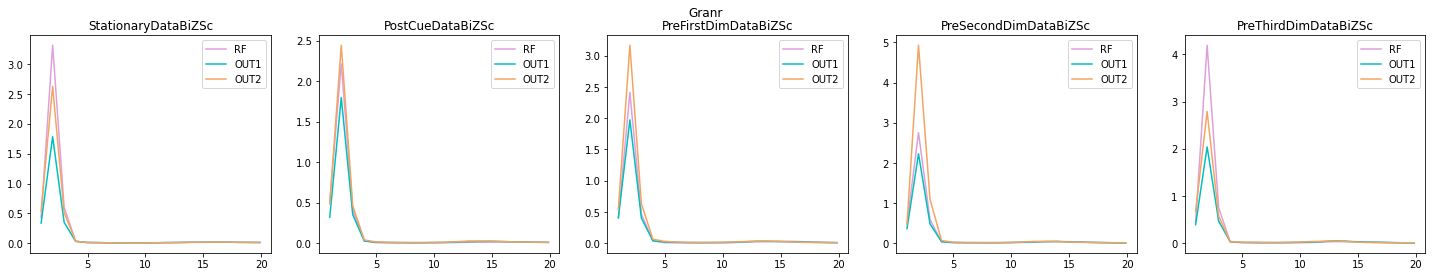

In [65]:
epochs = ['StationaryDataBiZSc','PostCueDataBiZSc','PreFirstDimDataBiZSc','PreSecondDimDataBiZSc','PreThirdDimDataBiZSc']
draw_avg_psd_algorithm2(lfp['Full']['Infra'],epochs,title='Infra',avg_type='median')
draw_avg_psd_algorithm2(lfp['Full']['Supra'],epochs,title='Supra',avg_type='median')
draw_avg_psd_algorithm2(lfp['Full']['Granr'],epochs,title='Granr',avg_type='median')



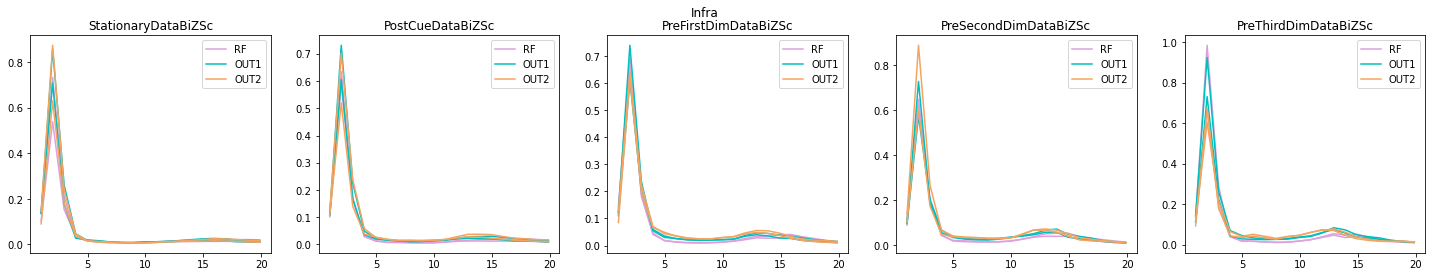

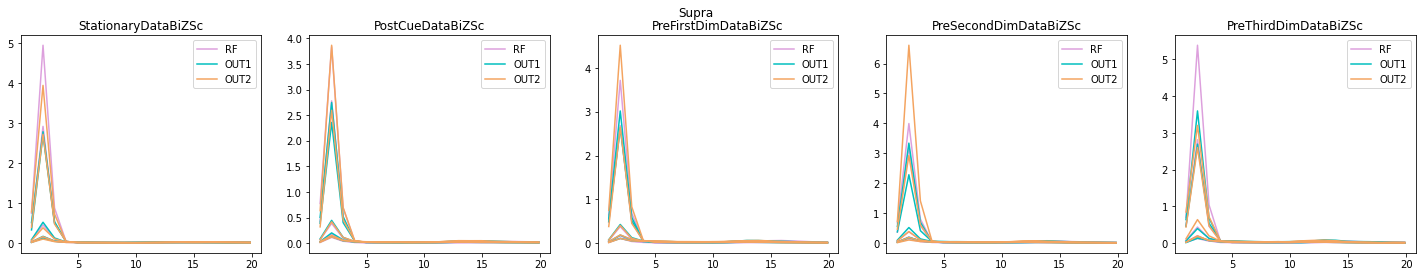

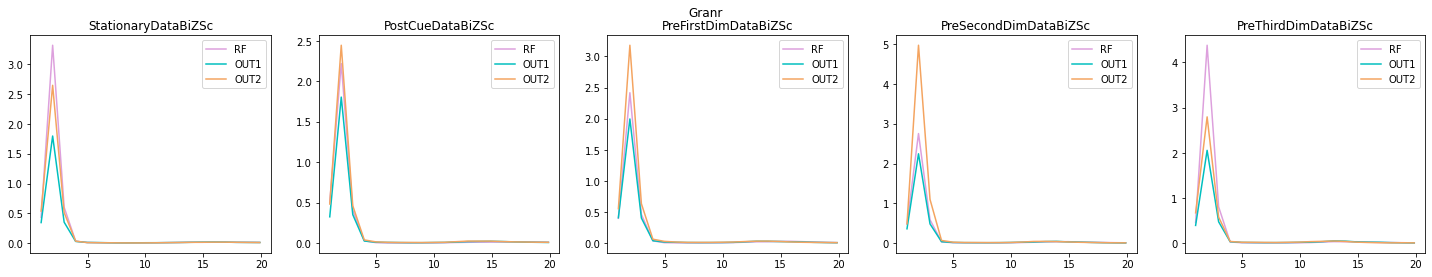

In [52]:
epochs = ['StationaryDataBiZSc','PostCueDataBiZSc','PreFirstDimDataBiZSc','PreSecondDimDataBiZSc','PreThirdDimDataBiZSc']
draw_avg_psd_algorithm1(lfp['Full']['Infra'],epochs,title='Infra',avg_type='mean')
draw_avg_psd_algorithm1(lfp['Full']['Supra'],epochs,title='Supra',avg_type='mean')
draw_avg_psd_algorithm1(lfp['Full']['Granr'],epochs,title='Granr',avg_type='mean')



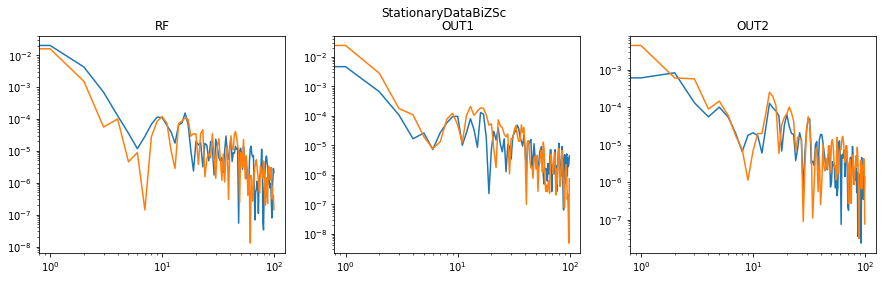

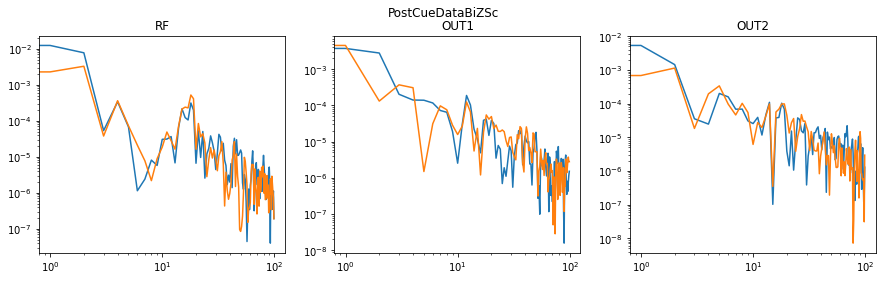

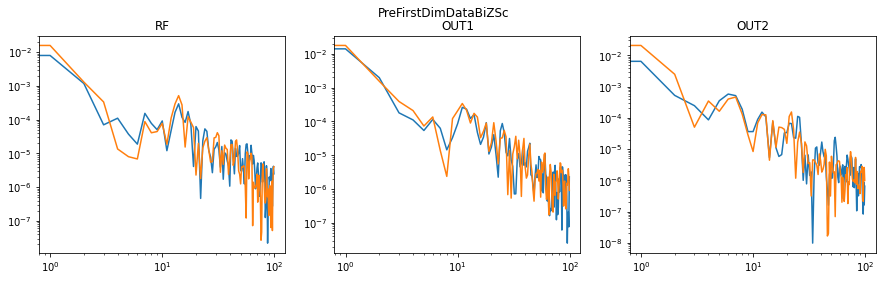

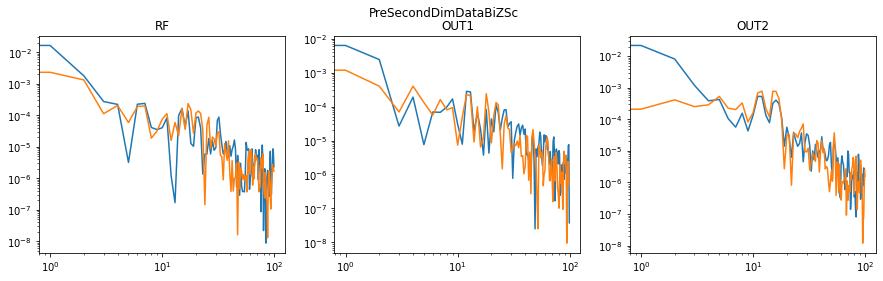

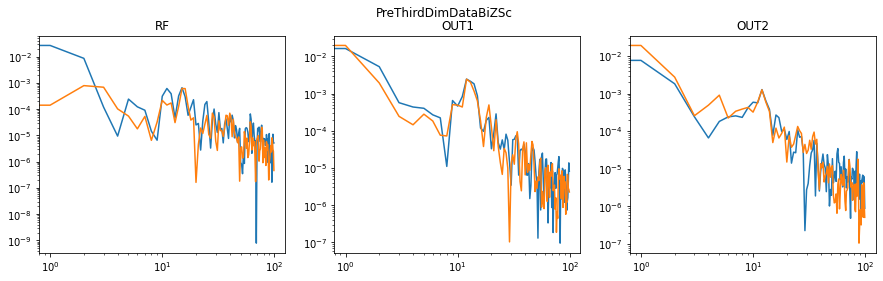

In [221]:
draw_psd(lfp['Full']['Infra'],'StationaryDataBiZSc',avg_type='median')
draw_psd(lfp['Full']['Infra'],'PostCueDataBiZSc',avg_type='median')
draw_psd(lfp['Full']['Infra'],'PreFirstDimDataBiZSc',avg_type='median')
draw_psd(lfp['Full']['Infra'],'PreSecondDimDataBiZSc',avg_type='median')
draw_psd(lfp['Full']['Infra'],'PreThirdDimDataBiZSc',avg_type='median')

In [ ]:
def draw_avg_lfp(data,epoch):
    rf = data['RF'][epoch]
    out1 = data['OUT1'][epoch]
    out2 = data['OUT2'][epoch]
    if len(rf.shape)==2:
        rf = rf.reshape((1,rf.shape[0],rf.shape[1]))
        out1 = out1.reshape((1,out1.shape[0],out1.shape[1]))
        out2 = out2.reshape((1,out2.shape[0],out2.shape[1]))
    timepoints = np.repeat(np.arange(0,1024),rf.shape[0]).reshape((1024,rf.shape[0])).T
    fig, axs = plt.subplots(1, 3, figsize=(20, 4))
    axs[0].plot(timepoints.T,np.average(rf,axis=1).T)
    axs[0].set_title('RF')
    axs[1].plot(timepoints.T,np.average(out1,axis=1).T)
    axs[1].set_title('OUT1')
    axs[2].plot(timepoints.T,np.average(out2,axis=1).T)
    axs[2].set_title('OUT2')
    fig.suptitle(epoch)
    plt.show()